# Clusterização de Acidentes

Notebook para agrupar dados de acidentes de trânsito usando K-Means, utilizando o máximo de colunas possível e mantendo o código conciso.

**Passos:**
1.  Carregar Dados
2.  Preparar Dados (Seleção Mínima, Imputação, Encoding, Escalonamento)
3.  Reduzir Dimensões (PCA)
4.  Agrupar (K-Means)
5.  Visualizar Clusters

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Config Gráficos
%matplotlib inline
sns.set_style('darkgrid')


## 1. Carregar Dados

Leitura do arquivo CSV com os dados dos acidentes.

In [10]:
caminho_arquivo = "Crash_Analysis_System_(CAS)_data.csv"
df_original = None

try:
    df_original = pd.read_csv(caminho_arquivo, low_memory=False)
    print(f"Dataset original carregado com {df_original.shape[0]} linhas e {df_original.shape[1]} colunas.")
except Exception as e:
    print(f"Erro ao carregar o CSV: {e}")


if df_original is not None:
    display(df_original.head())
else:
    print("DataFrame não carregado.")

Dataset original carregado com 869886 linhas e 72 colunas.


,X,Y,OBJECTID,advisorySpeed,areaUnitID,bicycle,bridge,bus,carStationWagon,cliffBank,...,train,tree,truck,unknownVehicleType,urban,vanOrUtility,vehicle,waterRiver,weatherA,weatherB
0,2037728.0,5709220.0,1,NaN,544500.0,1.0,NaN,0.0,1.0,NaN,...,NaN,NaN,0.0,0.0,Urban,0.0,NaN,NaN,Light rain,Null
1,1793829.0,5500169.0,2,NaN,564231.0,0.0,NaN,0.0,1.0,NaN,...,NaN,NaN,0.0,0.0,Urban,0.0,NaN,NaN,Fine,Null
2,1753976.0,5929363.0,3,NaN,508420.0,0.0,NaN,0.0,2.0,NaN,...,NaN,NaN,0.0,0.0,Urban,0.0,NaN,NaN,Fine,Null
3,1771836.0,5914911.0,4,NaN,521602.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,Urban,0.0,0.0,0.0,Light rain,Null
4,1752438.0,5918349.0,5,NaN,515002.0,0.0,NaN,0.0,2.0,NaN,...,NaN,NaN,0.0,0.0,Urban,0.0,NaN,NaN,Fine,Null


## 2. Preparar Dados

Seleção de colunas (remoção de IDs, etc.) e pré-processamento (imputação, encoding, escalonamento) para a maioria das colunas.

In [3]:

# Colunas a serem REMOVIDAS (IDs, Coordenadas, Vazias, Localização Textual)
colunas_para_remover = [
    'OBJECTID', 'meshblockId', 'areaUnitID', 'tlaId', # IDs
    'X', 'Y', # Coordenadas
    'crashLocation1', 'crashLocation2', 'tlaName', # Localização textual/alta cardinalidade
    'crashRoadSideRoad', 'intersection' # Colunas vazias identificadas anteriormente
]
df = None # Inicializar

if 'df_original' in locals() and df_original is not None:
    # Remover apenas as colunas especificadas que existem no DataFrame
    colunas_removidas_realmente = [col for col in colunas_para_remover if col in df_original.columns]
    df = df_original.drop(columns=colunas_removidas_realmente)
    print(f"Após remoção mínima, restaram {df.shape[1]} colunas.")

    # Separar tipos das colunas restantes
    colunas_numericas = df.select_dtypes(include=np.number).columns.tolist()
    colunas_categoricas = df.select_dtypes(include=['object', 'category']).columns.tolist()
    # print(f"Numéricas: {len(colunas_numericas)}, Categóricas: {len(colunas_categoricas)}")

    # Definir pipelines de pré-processamento
    preprocessor_numerico = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    preprocessor_categorico = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='Faltando')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    # Combinar no ColumnTransformer
    preprocessor_combinado = ColumnTransformer(
        transformers=[
            ('num', preprocessor_numerico, colunas_numericas),
            ('cat', preprocessor_categorico, colunas_categoricas)
        ],
        remainder='passthrough'
    )
else:
    print("Erro: df_original não está definido. Pré-processamento não pode continuar.")
    # Parar execução se df_original não foi carregado
    raise SystemExit("DataFrame original ausente.")



Após remoção mínima, restaram 61 colunas.


In [4]:

# Aplicar pré-processamento
X_processado = None
try:
    # Verificar se preprocessor_combinado foi definido
    if 'preprocessor_combinado' in locals() and preprocessor_combinado is not None and 'df' in locals() and df is not None:
        X_processado = preprocessor_combinado.fit_transform(df)
        print(f"Dimensões após pré-processamento: {X_processado.shape}") # Importante mostrar com muitas colunas
    else:
         print("Erro: Pré-processador ou DataFrame não definidos.")
         raise SystemExit("Falha no pré-processamento - setup incompleto.")
except MemoryError:
    print("ERRO DE MEMÓRIA durante o pré-processamento (provavelmente no OneHotEncoding).")
    print("Tente rodar novamente ou considere usar sparse=True no OneHotEncoder e ajustar o restante do código.")
    raise SystemExit("Falha no pré-processamento por memória.")
except Exception as e:
    print(f"Erro no pré-processamento: {e}")
    raise SystemExit("Falha no pré-processamento.")


Dimensões após pré-processamento: (65100, 145)


## 3. Reduzir Dimensões (PCA)

Aplicar PCA para reduzir as muitas dimensões resultantes do pré-processamento para apenas 2, facilitando a visualização e o K-Means.

In [5]:

# Aplicar PCA
X_pca = None
n_dimensoes_pca = 2
pca = PCA(n_components=n_dimensoes_pca, random_state=42)

try:
    # Verificar se X_processado existe antes de usar
    if 'X_processado' in locals() and X_processado is not None:
        X_pca = pca.fit_transform(X_processado)
        variancia_explicada = pca.explained_variance_ratio_.sum()
        print(f"PCA reduziu para {X_pca.shape[1]} dimensões, explicando {variancia_explicada:.1%} da variância.")
    else:
        print("Dados pré-processados não disponíveis para PCA.")
        raise SystemExit("Falha no PCA - dados ausentes.")
except Exception as e:
    print(f"Erro no PCA: {e}")
    raise SystemExit("Falha no PCA.")


PCA reduziu para 2 dimensões, explicando 8.0% da variância.


## 4. Agrupar com K-Means

Executar K-Means nos dados reduzidos pelo PCA para encontrar clusters.

In [7]:
# Executar K-Means
labels_kmeans = None
numero_clusters = 5 # Mantendo k=5
kmeans = KMeans(n_clusters=numero_clusters, random_state=42, n_init=10)

try:
    if 'X_pca' in locals() and X_pca is not None:
        labels_kmeans = kmeans.fit_predict(X_pca)

        # Calcular e mostrar Silhueta
        try:
            # Usar amostra menor para silhueta pode ser prudente com dados grandes
            score_silhueta = silhouette_score(X_pca, labels_kmeans, sample_size=min(50000, X_pca.shape[0]))
            print(f"Coeficiente de Silhueta: {score_silhueta:.3f}")
        except Exception as e_sil:
            print(f"(Aviso: Não foi possível calcular Silhueta: {e_sil})")

        # Mostrar contagem por cluster
        print("Contagem por cluster:")
        print(pd.Series(labels_kmeans).value_counts().sort_index())
    else:
        print("Dados do PCA não disponíveis para K-Means.")
        raise SystemExit("Falha no K-Means - dados ausentes.")

except Exception as e:
    print(f"Erro no K-Means: {e}")
    raise SystemExit("Falha no K-Means.")


Coeficiente de Silhueta: 0.423
Contagem por cluster:
0     9384
1    15247
2    23164
3    10881
4     6424
Name: count, dtype: int64


## 5. Visualizar Clusters

Gráfico de dispersão mostrando os clusters encontrados (baseado no PCA).

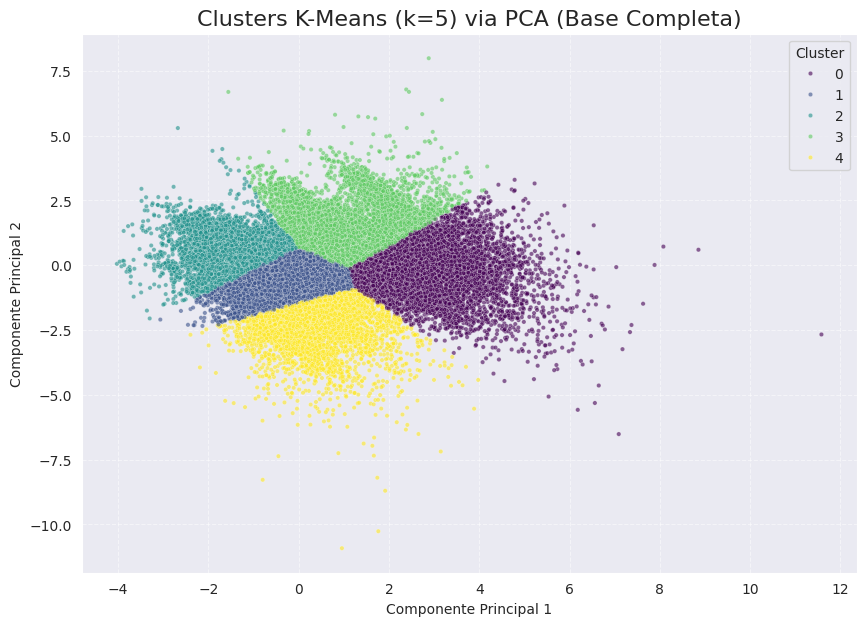

In [8]:
if 'X_pca' in locals() and X_pca is not None and 'labels_kmeans' in locals() and labels_kmeans is not None:
    df_plot = pd.DataFrame({
        'PCA1': X_pca[:, 0],
        'PCA2': X_pca[:, 1],
        'Cluster': labels_kmeans
    })

    plt.figure(figsize=(10, 7))
    sns.scatterplot(
        data=df_plot,
        x='PCA1',
        y='PCA2',
        hue='Cluster',
        palette='viridis',
        alpha=0.6,
        s=10,
        legend='full'
    )
    plt.title(f'Clusters K-Means (k={numero_clusters}) via PCA (Base Completa)', fontsize=16)
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()
else:
    print("Dados do PCA ou K-Means não disponíveis para visualização.")

